# Lab #1 Images, optics, and the statistics of light
## Section 3.1

In [43]:
# Import necessary packages
from glob import glob
import os
import numpy as np
import astropy.io.fits as fits
from astropy.visualization import PercentileInterval, ImageNormalize, SqrtStretch
import matplotlib.pyplot as plt
from photutils.aperture import ApertureStats, EllipticalAperture, aperture_photometry, CircularAnnulus
import matplotlib.ticker as ticker

In [8]:
# Important analytical values
gain = 8.07 # electrons/ADU
bias = 1.04e-2 # electrons
dark_current = 12.87 # electrons/second/pixel
read_noise = 4 # electrons
plate_scale = 20.87 #arcseconds per pixel


# Astronomical Measurements
## 2.3.1 Photometry

**Photometry:** 

**KEY STEPS:**
1) Measure the flux and flux uncertainty of Jupiter-sim's red spot.
2) Determine the signal-to-noise ratio on Jupiter-sim’s red spot in a 1 second integration

In [9]:
spot_directory = "new/fits/jupiter" # Path to star cluster files
spot_files = glob(os.path.join(spot_directory, '*.fits'))

print(f"\nFound {len(spot_files)} files in '{spot_directory}'.\n")


Found 18 files in 'new/fits/jupiter'.



In [115]:
flat_file = "gain/1s/fits/1_1000000us.fits"
dark_file = "bias/trial_1/5us/fits/dark_frame1_5us.fits"

flat_frame = fits.getdata(flat_file) * gain
dark_frame = fits.getdata(dark_file) * gain


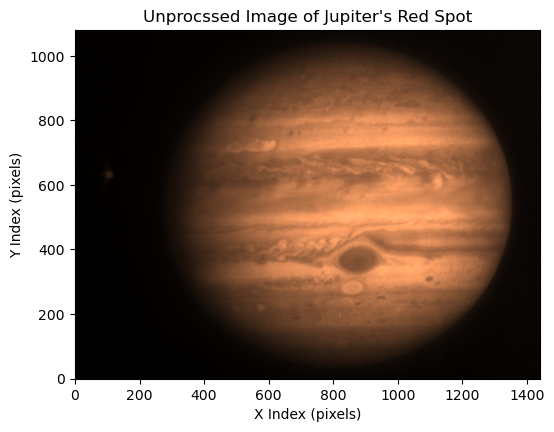

In [143]:
sum_spot_data = np.zeros_like(fits.getdata(spot_files[0]))
one_spot = []

for spot_file in spot_files:
    unclean_spot_data = fits.getdata(spot_file) * gain
    spot_data = (unclean_spot_data - dark_frame) / (flat_frame - dark_frame)
    
    sum_spot_data += spot_data

    if spot_file == spot_files[0]:
        one_spot.append(spot_data)

unflipped_image_data = sum_spot_data / len(spot_files)
mean_spot_data = np.flipud(unflipped_image_data)

one_spot_data = np.flipud(np.array(one_spot))

interval = PercentileInterval(99) # Get rid of extreme outliers
vmin, vmax = interval.get_limits(mean_spot_data)
norm = ImageNormalize(mean_spot_data, vmin=vmin, vmax=vmax, stretch=SqrtStretch())

plt.figure(figsize=(6, 6))
plt.title("Unprocssed Image of Jupiter's Red Spot")
plt.xlabel('X Index (pixels)')
plt.ylabel('Y Index (pixels)')
#plt.scatter(x_center, y_center, color='green', label='Center')
plt.imshow(mean_spot_data, cmap='copper', origin='lower')
plt.show()

In [144]:
print(mean_spot_data[660, 400])

0.825684380032206


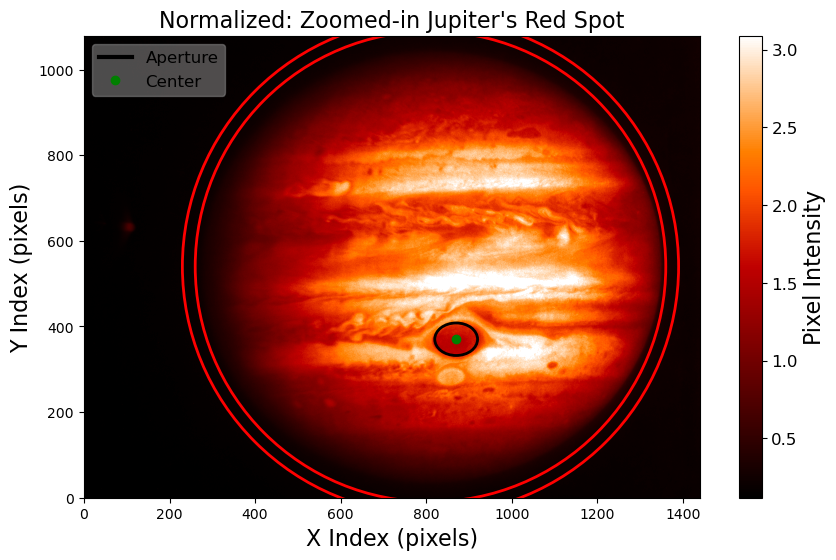

In [148]:
semi_minor_axis = 38
semi_major_axis = 50

x_center = 870
y_center = 370

center = ([810, 540])

#semi_minor_axis = 33
#semi_major_axis = 56

#x_center = 62
#y_center = 46

#center = ([810, 540])

theta = np.pi / 2

ellipse_aperture = EllipticalAperture((x_center, y_center), semi_minor_axis, semi_major_axis, theta)
annulus_aperture = CircularAnnulus(center, r_in=550, r_out=580)

fig, ax = plt.subplots(figsize=(10, 6))

one_spot_data= np.squeeze(np.flipud(one_spot_data))

#vmin, vmax = interval.get_limits(mean_spot_data[320:420,810:960])
#norm = ImageNormalize(mean_spot_data, vmin=vmin, vmax=vmax, stretch=SqrtStretch())

#ellipse_aperture.plot(color='white')
ax.set_title("Normalized: Zoomed-in Jupiter's Red Spot", fontsize=16)
ax.set_xlabel('X Index (pixels)', fontsize=16)
ax.set_ylabel('Y Index (pixels)', fontsize=16)
ax.scatter(x_center, y_center, color='green', label = 'Center')
img = ax.imshow(one_spot_data, cmap='gist_heat', origin='lower')
ellipse_aperture.plot(color='black', lw=2)
annulus_aperture.plot(color='red', lw=2)
center_legend_line = plt.Line2D([0], [0], marker='o', color='g', lw=0, label='Center')
aperture_legend_line = plt.Line2D([0], [0], color='black', lw=3, label='Aperture')
annulus_legend_line = plt.Line2D([0], [0], color='red', lw=3, label='Annulus')
legend2 = ax.legend(handles=[aperture_legend_line, center_legend_line], loc='upper left', fontsize=12)
legend2.get_frame().set_alpha(.3)
plt.setp(legend2.get_texts(), color='black')

cbar = fig.colorbar(img)
cbar.ax.tick_params(labelsize=12)
img.set_clim(vmin=vmin, vmax=vmax) 

cbar.set_label('Pixel Intensity', fontsize=16)


plt.show()

In [153]:
aperture_stats_emp = ApertureStats(one_spot_data, ellipse_aperture)
annulus_stats_emp = ApertureStats(one_spot_data, annulus_aperture)
sum_signal_emp = aperture_stats_emp.sum
mean_background_emp = annulus_stats_emp.mean
aperture_area_emp = ellipse_aperture.area_overlap(one_spot_data)

print(f"\nMeasured signal from the spot is {np.round(sum_signal_emp)} (electrons).")
print(f"Background is {mean_background_emp} (electrons/pixel).\n")


Measured signal from the spot is 9942.0 (electrons).
Background is 0.22023019701716198 (electrons/pixel).



In [128]:
aperture_stats = ApertureStats(mean_spot_data, ellipse_aperture)
annulus_stats = ApertureStats(mean_spot_data, annulus_aperture)
sum_signal = aperture_stats.sum
mean_background = annulus_stats.mean
aperture_area = ellipse_aperture.area_overlap(mean_spot_data)

print(f"\nMeasured signal from the spot is {np.round(sum_signal)} (electrons).")
print(f"Background is {mean_background} (electrons/pixel).\n")


Measured signal from the spot is 9836.0 (electrons).
Background is 0.21915789950979786 (electrons/pixel).



In [10]:
#background_directory = "gain/1s/fits/1_1000000us.fits"
#background_data = fits.getdata(background_directory)
#mean_background = np.mean(background_data)
#print(mean_background)

1084.1695936213991


In [154]:
measured_signal_emp = sum_signal_emp 
uncertainty_measured_signal_emp = np.sqrt(sum_signal_emp)

empirical_signal_to_noise_ratio_emp = measured_signal_emp / uncertainty_measured_signal_emp

print(f"\nThe analytical signal-to-noise ratio is {np.round(empirical_signal_to_noise_ratio_emp, 2)}.")
print(f"Jupiter's analytical flux is {np.round(measured_signal_emp)} +/- {np.round(uncertainty_measured_signal_emp)} (electrons) .\n")
print(f"Jupiter's analytical flux is {np.round(measured_signal_emp)} +/- {np.round(uncertainty_measured_signal_emp)} (electrons) .\n")




The analytical signal-to-noise ratio is 99.71.
Jupiter's analytical flux is 9942.0 +/- 100.0 (electrons) .

Jupiter's analytical flux is 9942.0 +/- 100.0 (electrons) .



In [130]:
measured_signal = sum_signal - (mean_background * 400) - (bias) - (dark_current)
uncertainty_measured_signal = np.sqrt(sum_signal - (mean_background) - bias - (dark_current))

analytical_signal_to_noise_ratio = measured_signal / uncertainty_measured_signal

print(f"\nThe analytical signal-to-noise ratio is {np.round(analytical_signal_to_noise_ratio, 2)}.")
print(f"Jupiter's analytical flux is {np.round(measured_signal)} +/- {np.round(uncertainty_measured_signal)} (electrons) .\n")
print(f"Jupiter's analytical flux is {np.round(measured_signal)} +/- {np.round(uncertainty_measured_signal)} (electrons) .\n")




The analytical signal-to-noise ratio is 98.23.
Jupiter's analytical flux is 9736.0 +/- 99.0 (electrons) .



Text(0.5, 1.0, 'Star Cluster')

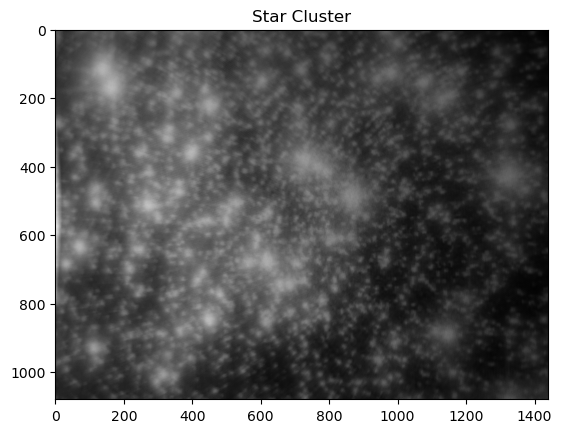

In [12]:
data = fits.getdata("new/fits/stars_1000us.fits")
plt.imshow(data, cmap='gray')
plt.title("Star Cluster")